In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth https://download.openmmlab.com/mmsegmentation/v0.5/sem_fpn/fpn_r101_512x1024_80k_cityscapes/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-09 02:59:51--  https://download.openmmlab.com/mmsegmentation/v0.5/sem_fpn/fpn_r101_512x1024_80k_cityscapes/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190509585 (182M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth’

//content/mmsegment 100%[===================>] 181.68M  13.8MB/s    in 14s     

2022-05-09 03:00:06 (13.3 MB/s) - ‘//content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth’ saved [190509585/190509585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building', 'road')
palette = [[0, 0, 0], [128, 128, 0], [128, 64, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/sem_fpn/fpn_r101_512x1024_80k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1

In [ ]:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))
log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
cudnn_benchmark = True
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005)
optimizer_config = dict()
lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)
runner = dict(type='IterBasedRunner', max_iters=80000)
checkpoint_config = dict(by_epoch=False, interval=8000)
evaluation = dict(interval=8000, metric='mIoU', pre_eval=True)

In [ ]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [ ]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [ ]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 3

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 1024)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'
cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'images/up025'
cfg.data.val.ann_dir = 'labels'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/splits/road/val_road.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'images/up025'
cfg.data.test.ann_dir = 'labels'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/splits/road/val_road.txt'

In [ ]:
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 50
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=10000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-09 03:00:07,234 - mmseg - INFO - Loaded 463 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-09 03:00:10,861 - mmseg - INFO - Loaded 223 images
2022-05-09 03:00:10,867 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth
2022-05-09 03:00:11,092 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 6.9 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:05:47,061 - mmseg - INFO - per class results:
2022-05-09 03:05:47,063 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.03 | 99.02 |
|  building  |  nan  |  nan  |
|    road    | 40.07 | 42.63 |
+------------+-------+-------+
2022-05-09 03:05:47,065 - mmseg - INFO - Summary:
2022-05-09 03:05:47,067 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.54 | 65.55 | 70.83 |
+-------+-------+-------+
2022-05-09 03:05:47,071 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9154, mIoU: 0.6555, mAcc: 0.7083, IoU.background: 0.9103, IoU.building: nan, IoU.road: 0.4007, Acc.background: 0.9902, Acc.building: nan, Acc.road: 0.4263
2022-05-09 03:06:01,603 - mmseg - INFO - Iter [1050/10000]	lr: 9.060e-03, eta: 0:49:46, time: 0.935, data_time: 0.649, memory: 3707, decode.loss_ce: 0.2206, decode.acc_seg: 90.7814, loss: 0.2206
2022-05-09 03:06:16,160 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 7.0 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:11:23,227 - mmseg - INFO - per class results:
2022-05-09 03:11:23,229 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.65 |  96.3 |
|  building  |  nan  |  nan  |
|    road    | 53.82 | 66.85 |
+------------+-------+-------+
2022-05-09 03:11:23,230 - mmseg - INFO - Summary:
2022-05-09 03:11:23,232 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.39 | 72.73 | 81.57 |
+-------+-------+-------+
2022-05-09 03:11:23,234 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9239, mIoU: 0.7273, mAcc: 0.8157, IoU.background: 0.9165, IoU.building: nan, IoU.road: 0.5382, Acc.background: 0.9630, Acc.building: nan, Acc.road: 0.6685
2022-05-09 03:11:37,844 - mmseg - INFO - Iter [2050/10000]	lr: 8.154e-03, eta: 0:44:22, time: 0.934, data_time: 0.648, memory: 3707, decode.loss_ce: 0.2091, decode.acc_seg: 91.3620, loss: 0.2091
2022-05-09 03:11:54,721 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 6.9 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:16:57,904 - mmseg - INFO - per class results:
2022-05-09 03:16:57,906 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  92.3 | 97.69 |
|  building  |  nan  |  nan  |
|    road    | 53.72 | 61.83 |
+------------+-------+-------+
2022-05-09 03:16:57,907 - mmseg - INFO - Summary:
2022-05-09 03:16:57,910 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.93 | 73.01 | 79.76 |
+-------+-------+-------+
2022-05-09 03:16:57,912 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9293, mIoU: 0.7301, mAcc: 0.7976, IoU.background: 0.9230, IoU.building: nan, IoU.road: 0.5372, Acc.background: 0.9769, Acc.building: nan, Acc.road: 0.6183
2022-05-09 03:17:14,754 - mmseg - INFO - Iter [3050/10000]	lr: 7.236e-03, eta: 0:38:52, time: 0.979, data_time: 0.694, memory: 3707, decode.loss_ce: 0.1975, decode.acc_seg: 91.8053, loss: 0.1975
2022-05-09 03:17:29,321 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 7.0 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:22:35,846 - mmseg - INFO - per class results:
2022-05-09 03:22:35,848 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.35 | 98.62 |
|  building  |  nan  |  nan  |
|    road    |  51.0 | 55.61 |
+------------+-------+-------+
2022-05-09 03:22:35,849 - mmseg - INFO - Summary:
2022-05-09 03:22:35,851 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.91 | 71.67 | 77.11 |
+-------+-------+-------+
2022-05-09 03:22:35,854 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9291, mIoU: 0.7167, mAcc: 0.7711, IoU.background: 0.9235, IoU.building: nan, IoU.road: 0.5100, Acc.background: 0.9862, Acc.building: nan, Acc.road: 0.5561
2022-05-09 03:22:50,442 - mmseg - INFO - Iter [4050/10000]	lr: 6.305e-03, eta: 0:33:16, time: 0.933, data_time: 0.647, memory: 3707, decode.loss_ce: 0.1738, decode.acc_seg: 92.5123, loss: 0.1738
2022-05-09 03:23:05,019 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 6.9 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:28:10,266 - mmseg - INFO - per class results:
2022-05-09 03:28:10,268 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.76 | 97.47 |
|  building  |  nan  |  nan  |
|    road    |  57.3 | 66.76 |
+------------+-------+-------+
2022-05-09 03:28:10,269 - mmseg - INFO - Summary:
2022-05-09 03:28:10,271 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.4 | 75.03 | 82.12 |
+------+-------+-------+
2022-05-09 03:28:10,274 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9340, mIoU: 0.7503, mAcc: 0.8212, IoU.background: 0.9276, IoU.building: nan, IoU.road: 0.5730, Acc.background: 0.9747, Acc.building: nan, Acc.road: 0.6676
2022-05-09 03:28:24,861 - mmseg - INFO - Iter [5050/10000]	lr: 5.358e-03, eta: 0:27:40, time: 0.934, data_time: 0.648, memory: 3707, decode.loss_ce: 0.1719, decode.acc_seg: 92.5026, loss: 0.1719
2022-05-09 03:28:41,764 - mmseg - INFO - Iter [51

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 6.9 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:33:44,664 - mmseg - INFO - per class results:
2022-05-09 03:33:44,667 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.93 | 98.04 |
|  building  |  nan  |  nan  |
|    road    | 56.77 | 64.03 |
+------------+-------+-------+
2022-05-09 03:33:44,668 - mmseg - INFO - Summary:
2022-05-09 03:33:44,672 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.53 | 74.85 | 81.04 |
+-------+-------+-------+
2022-05-09 03:33:44,675 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9353, mIoU: 0.7485, mAcc: 0.8104, IoU.background: 0.9293, IoU.building: nan, IoU.road: 0.5677, Acc.background: 0.9804, Acc.building: nan, Acc.road: 0.6403
2022-05-09 03:34:01,581 - mmseg - INFO - Iter [6050/10000]	lr: 4.392e-03, eta: 0:22:05, time: 0.981, data_time: 0.695, memory: 3707, decode.loss_ce: 0.1799, decode.acc_seg: 92.3797, loss: 0.1799
2022-05-09 03:34:16,143 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 7.0 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:39:22,312 - mmseg - INFO - per class results:
2022-05-09 03:39:22,313 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.94 | 97.54 |
|  building  |  nan  |  nan  |
|    road    |  58.3 | 67.69 |
+------------+-------+-------+
2022-05-09 03:39:22,315 - mmseg - INFO - Summary:
2022-05-09 03:39:22,316 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.58 | 75.62 | 82.61 |
+-------+-------+-------+
2022-05-09 03:39:22,319 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9358, mIoU: 0.7562, mAcc: 0.8261, IoU.background: 0.9294, IoU.building: nan, IoU.road: 0.5830, Acc.background: 0.9754, Acc.building: nan, Acc.road: 0.6769
2022-05-09 03:39:36,866 - mmseg - INFO - Iter [7050/10000]	lr: 3.401e-03, eta: 0:16:29, time: 0.932, data_time: 0.647, memory: 3707, decode.loss_ce: 0.1619, decode.acc_seg: 92.9232, loss: 0.1619
2022-05-09 03:39:51,409 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 7.0 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:44:56,209 - mmseg - INFO - per class results:
2022-05-09 03:44:56,211 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.92 | 97.34 |
|  building  |  nan  |  nan  |
|    road    |  58.7 | 68.91 |
+------------+-------+-------+
2022-05-09 03:44:56,212 - mmseg - INFO - Summary:
2022-05-09 03:44:56,214 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.57 | 75.81 | 83.13 |
+-------+-------+-------+
2022-05-09 03:44:56,216 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9357, mIoU: 0.7581, mAcc: 0.8313, IoU.background: 0.9292, IoU.building: nan, IoU.road: 0.5870, Acc.background: 0.9734, Acc.building: nan, Acc.road: 0.6891
2022-05-09 03:45:10,759 - mmseg - INFO - Iter [8050/10000]	lr: 2.374e-03, eta: 0:10:53, time: 0.931, data_time: 0.646, memory: 3707, decode.loss_ce: 0.1469, decode.acc_seg: 93.6302, loss: 0.1469
2022-05-09 03:45:27,577 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 7.0 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:50:30,044 - mmseg - INFO - per class results:
2022-05-09 03:50:30,046 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.19 | 97.64 |
|  building  |  nan  |  nan  |
|    road    | 59.57 | 68.75 |
+------------+-------+-------+
2022-05-09 03:50:30,047 - mmseg - INFO - Summary:
2022-05-09 03:50:30,049 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.81 | 76.38 | 83.2 |
+-------+-------+------+
2022-05-09 03:50:30,055 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9381, mIoU: 0.7638, mAcc: 0.8320, IoU.background: 0.9319, IoU.building: nan, IoU.road: 0.5957, Acc.background: 0.9764, Acc.building: nan, Acc.road: 0.6875
2022-05-09 03:50:46,909 - mmseg - INFO - Iter [9050/10000]	lr: 1.291e-03, eta: 0:05:18, time: 0.976, data_time: 0.691, memory: 3707, decode.loss_ce: 0.1414, decode.acc_seg: 93.9688, loss: 0.1414
2022-05-09 03:51:01,445 - mmseg - INFO - Iter [91

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 7.0 task/s, elapsed: 32s, ETA:     0s

2022-05-09 03:56:07,884 - mmseg - INFO - per class results:
2022-05-09 03:56:07,886 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 93.32 | 97.58 |
|  building  |  nan  |  nan  |
|    road    | 60.54 |  70.1 |
+------------+-------+-------+
2022-05-09 03:56:07,887 - mmseg - INFO - Summary:
2022-05-09 03:56:07,889 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.94 | 76.93 | 83.84 |
+-------+-------+-------+
2022-05-09 03:56:07,894 - mmseg - INFO - Iter(val) [223]	aAcc: 0.9394, mIoU: 0.7693, mAcc: 0.8384, IoU.background: 0.9332, IoU.building: nan, IoU.road: 0.6054, Acc.background: 0.9758, Acc.building: nan, Acc.road: 0.7010


/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


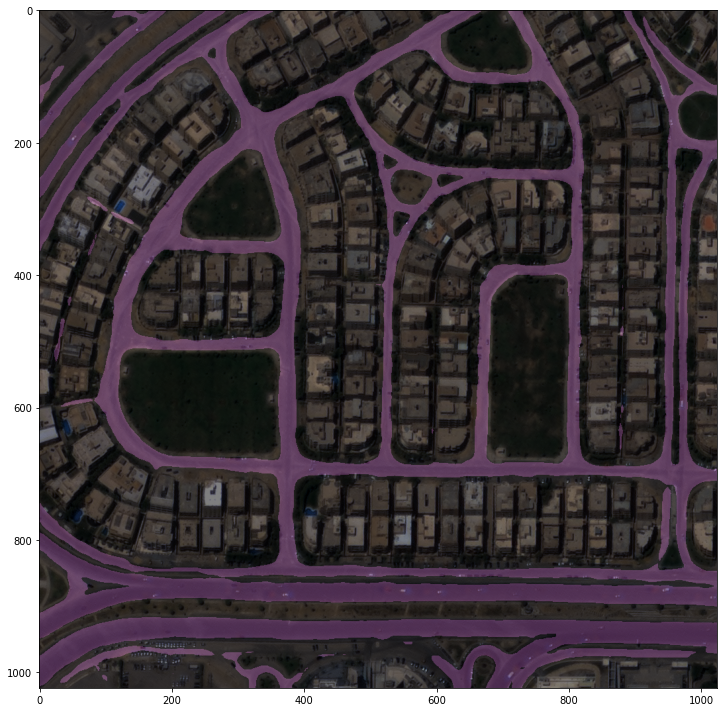

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/up025/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


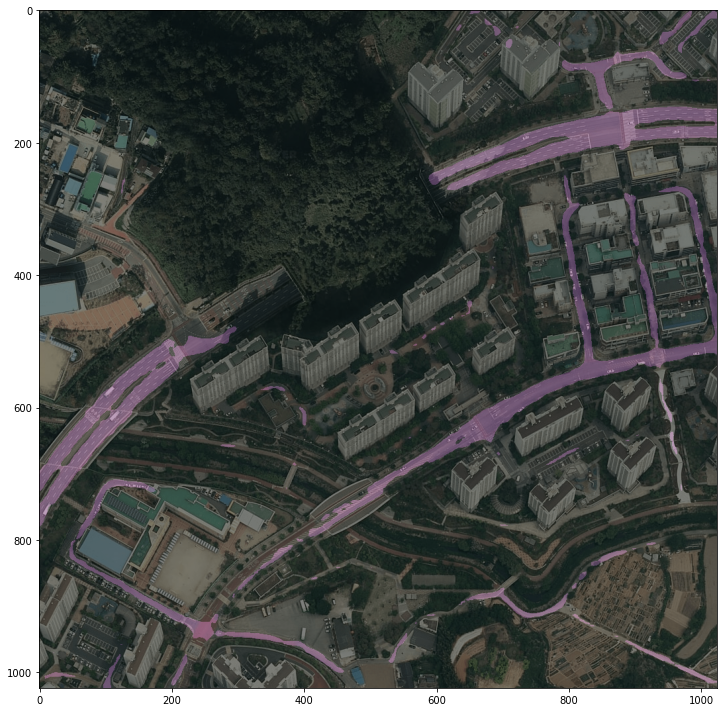

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


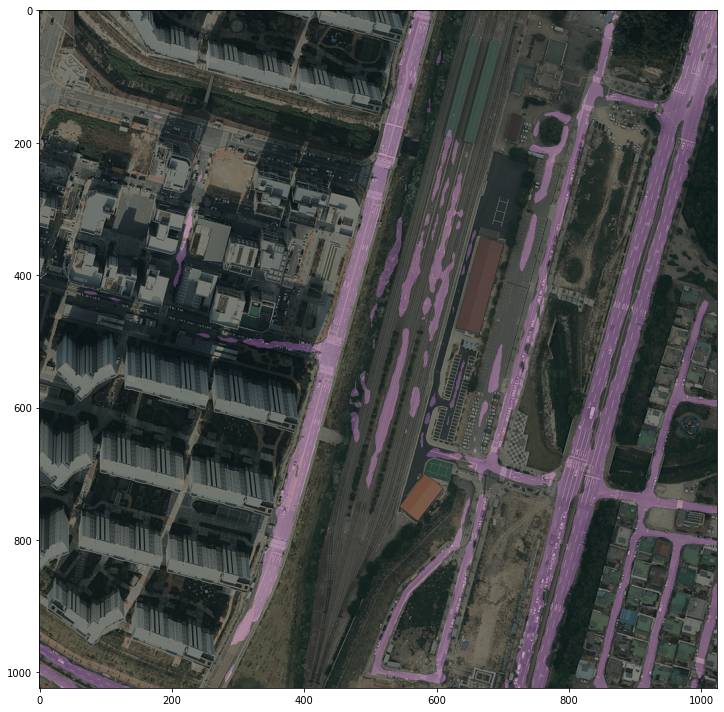

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


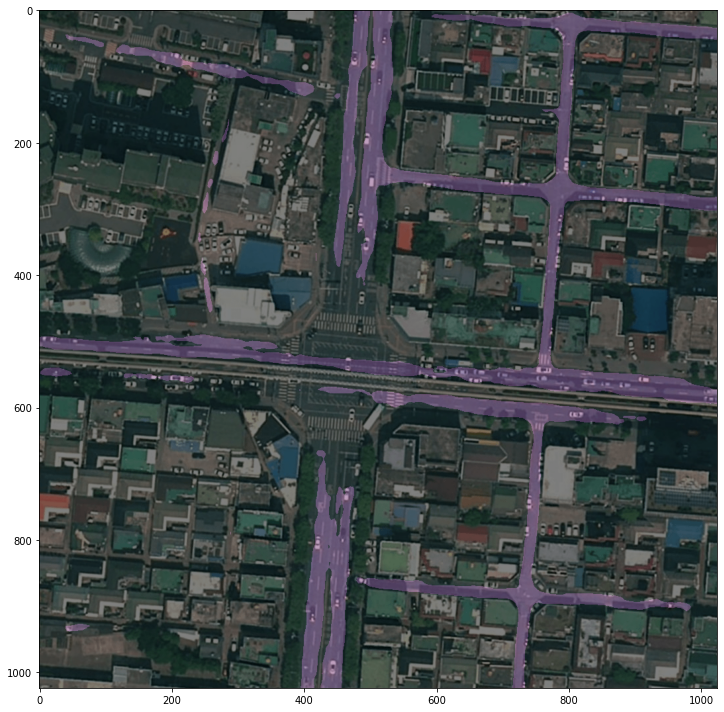

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_road/iter_10000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)